In [1]:
%%capture output
%pip install numpy
%pip install matplotlib

The description of the 2d problem is very limited, im going to assume we do weighted resampling, ans use the basically alg 1 of the other paper form green maskell

In [76]:
import numpy as np
import matplotlib.pyplot as plt

def bivar_normal_p(sample, mean, covar):
    x_minus_mean = np.subtract(sample,mean)
    temp1 = np.dot(x_minus_mean.T,np.linalg.inv(covar))
    temp2 = np.dot(temp1,x_minus_mean)
    n = len(sample)
    k = (((2*np.pi)**(n/2))*((np.linalg.det(covar))**(1/2)))**-1
    return k*(np.e**(-0.5*temp2))

def target_dist_prob(sample):
    "returns how close a sample is to target dist"
    return bivar_normal_p(sample,[3,2],np.eye(2))

def initial_proposal_prob(sample):
    return bivar_normal_p(sample,[0,0],np.eye(2))

def initial_proposal(n):
    return np.random.randn(n,2)

def get_neff(weights):
    sum_w_squared = 0
    for w in weights:
        sum_w_squared +=  w**2
    return 1/sum_w_squared

def generate_approx_opt_l_kernel(x_arr,x_hat_arr):
    x_arr, x_hat_arr = np.array(x_arr), np.array(x_hat_arr)
    assert x_arr.shape == x_hat_arr.shape
    # generate the means and covars of all samples
    X = np.hstack([x_arr]+[x_hat_arr])
    mu = np.mean(X,axis=0)
    mu_x, mu_xh = mu[:2], mu[2:]
    # idk whether i should do the np.eye(2)*1e-6 thing here to 'avoid singularities'
    # like pl green does in his code
    covar = np.cov(X.T)
    covarxx = covar[:2,:2]
    covarxhxh = covar[2:,2:]
    covarxxh = covar[:2,2:]
    covarxhxhinv = np.linalg.inv(covarxhxh)

    return mu_x, mu_xh, covarxx, covarxxh, covarxhxhinv
    # mean x conditional xhat

def sample_optimal_l_kernel(mu_x, mu_xh,covarxx,covarxxh, covarxhxhinv,
                            theta,theta_hat):
    mu_tcth = mu_x + covarxxh @ covarxhxhinv @ (theta_hat-mu_xh)
    covar_tcth = covarxx - covarxxh @ covarxhxhinv @ covarxxh.T
    return bivar_normal_p(theta, mu_tcth, covar_tcth)

def gen_test_set(n = 10, mu1 = [1,2], mu2 = [1.2,2.2]):
    theta, theta_hat = [],[]
    for _ in range(n):
        theta.append(mu1+np.random.randn(len(mu1)))
        theta_hat.append(mu2+np.random.randn(len(mu2)))
    return np.array(theta), np.array(theta_hat)


def forward_proposal_l_kernel(theta,theta_hat,covar):
    return bivar_normal_p(theta,theta_hat,covar)

def forward_proposal_prob(theta,theta_hat, covar):
    return bivar_normal_p(theta_hat,theta,covar)

def get_initial_weights(samples):
    return [target_dist_prob(s)/initial_proposal_prob(s) for s in samples]

def normalise_weights(weights):
    return weights/sum(weights)

def get_lk(weights):
    weights_squared = np.multiply(weights,weights)
    return sum(weights)**2/sum(weights_squared)


def get_ck_opt_arr(weights_arr):
    ck = []
    for weights in weights_arr:
        ck.append(get_lk(weights))
    # normalise and return
    return ck/sum(ck)
        

def get_y_guess_with_ck(samples_arr,weights_arr)->list[float]:
    estimate = [0,0]
    ck_arr = get_ck_opt_arr(weights_arr)
    for samples, weights, ck in zip(samples_arr,weights_arr,ck_arr):
        for sample,weight in zip(samples, weights):
            estimate += weight * sample * ck
    return estimate

def normal_y_guess(samples,weights):
    y1,y2 = 0,0
    for w,s in zip(weights, samples):
        s1,s2 = s
        y1+=w*s1
        y2+=w*s2
    return y1,y2

def reset_weights(n):
    return [1/n]*n          

def weighted_resample(samples,weights):
    index = np.arange(0,len(samples))
    sample_index = np.random.choice(index,len(index),p=weights)
    return [samples[si] for si in sample_index]

def forward_proposal(samples,covar_mat):
    samples = np.array(samples)
    var = covar_mat[0][0]
    return samples+np.random.randn(len(samples),len(samples[0]))*var

def new_weights_sub(weights, theta_arr, theta_hat_arr, covar):
    """gets the new weights using the optimal l kernel"""
    new_weights = []
    for w, theta, theta_hat in zip(weights,theta_arr, theta_hat_arr):
        targ_ratio = target_dist_prob(theta_hat)/target_dist_prob(theta)
        l_kern_proposal_ratio = forward_proposal_l_kernel(theta,theta_hat,covar)/(forward_proposal_prob(theta,theta_hat,covar))
        new_weights.append(targ_ratio*l_kern_proposal_ratio*w)
    return new_weights


def new_weights_opt(weights, theta_arr, theta_hat_arr,covar):
    """gets the new weights using the optimal l kernel"""
    new_weights = []
    l_kern = generate_approx_opt_l_kernel(theta_arr, theta_hat_arr)
    for w, theta, theta_hat in zip(weights,theta_arr, theta_hat_arr):
        targ_ratio = target_dist_prob(theta_hat)/target_dist_prob(theta)
        l_kern_proposal_ratio = sample_optimal_l_kernel(*l_kern, theta, theta_hat)/(forward_proposal_prob(theta,theta_hat,covar))
        new_weights.append(targ_ratio*l_kern_proposal_ratio*w)

    return new_weights

def sub_optimal_loop(n=500, t_total=101):
    t = 1
    samples, weights, y_guess = [], [], []
    samples.append(initial_proposal(n))
    weights.append(get_initial_weights(samples[-1]))
    proposal_covar_mat = np.eye(2)
    resample_count = 0

    while t<t_total:
        weights[-1] = normalise_weights(weights[-1])
        y_guess.append(get_y_guess_with_ck(samples,weights))
        neff = get_neff(weights[-1])
        if neff<(n/2):
            samples[-1] = weighted_resample(samples[-1], weights[-1])
            weights[-1] = reset_weights(n)
            resample_count+=1
        t += 1
        samples.append(forward_proposal(samples[-1],proposal_covar_mat))
        # only thing that chages in the main loop is the new_weights function
        weights.append(new_weights_sub(weights[-1],samples[-2], samples[-1],proposal_covar_mat)) 

    weights[-1] = normalise_weights(weights[-1])
    print(f'the number of resamples for suboptimal loop was: {resample_count}')
    return y_guess

def optimal_loop(n=500, t_total=101):
    t = 1
    samples, weights, y_guess = [], [], []
    samples.append(initial_proposal(n))
    weights.append(get_initial_weights(samples[-1]))
    proposal_covar_mat = np.eye(2)
    resample_count = 0

    while t<t_total:
        weights[-1] = normalise_weights(weights[-1])
        y_guess.append(get_y_guess_with_ck(samples,weights))
        neff = get_neff(weights[-1])
        if neff<(n/2):
            samples[-1] = weighted_resample(samples[-1], weights[-1])
            weights[-1] = reset_weights(n)
            resample_count+=1
        t += 1
        samples.append(forward_proposal(samples[-1],proposal_covar_mat))
        # only thing that chages in the main loop is the new_weights function
        weights.append(new_weights_opt(weights[-1],samples[-2], samples[-1],proposal_covar_mat)) 

    weights[-1] = normalise_weights(weights[-1])
    print(f'the number of resamples for optimal loop was: {resample_count}')
    return y_guess

n, t_total = 500, 101
y_guess_sub = np.array(sub_optimal_loop(n ,t_total))
y_guess_opt = np.array(optimal_loop(n, t_total))

the number of resamples for suboptimal loop was: 100
the number of resamples for optimal loop was: 35


## Plotting y_guess for x1 x2

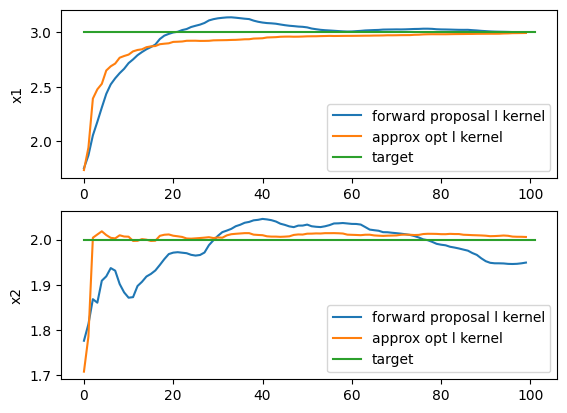

In [77]:
fig, ax = plt.subplots(2)
ax[0].plot(y_guess_sub[:,0], label='forward proposal l kernel')
ax[0].plot(y_guess_opt[:,0], label='approx opt l kernel')
ax[1].plot(y_guess_sub[:,1], label='forward proposal l kernel')
ax[1].plot(y_guess_opt[:,1], label='approx opt l kernel')
ax[0].plot([0,t_total],[3,3], label='target')
ax[1].plot([0,t_total],[2,2], label='target')
ax[0].set_ylabel('x1')
ax[1].set_ylabel('x2')

ax[0].legend()
ax[1].legend()

plt.show()

this is the optimal l kernel for 1d, this doesn't not scale up to multiple target params (so a taget vector), hence the name of the paper being approximately optimal l kernels as the next section lays out the approximate or multipdimensional approch

![image](images/optimal_l_1d.jpg)

# approx optimal l kernels, 2 solutions given in paper:

## gaussian approximation

![image](images/gauss_approx.jpg)

## mixture of mixture of gaussian approximation

![image](images/gauss_mix.jpg)

* we will try to use gaussian approximation first

# Notes 
* i think the gaussian mixture would be used for gaussian processes when you are proposing multiple different kernel funcitons within the gp that all have their own hyperparams to optimise (which would then be theta, although surely the dimentsions of theta will change idk) - should probably ask about gaussian mixture althoug hmaybe the next problem in the paper uses the mixture.